In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [2]:
#memanggil file

for dirname, _, filenames in os.walk('/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#Resize ukuran dataset 
IMAGE_SIZE = 200

In [4]:
img_dir = "Dataset/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

In [5]:
#labeling data set dan fungsi resizeannotation

from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [6]:
path = 'Dataset/annotations'
text_files = ['Dataset/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [7]:
resizeannotation("Dataset/annotations/Cars147.xml")

[168, 126, 90, 93]

In [8]:
y[0]

[167, 129, 90, 93]

In [9]:
np.array(X).shape

(433, 200, 200, 3)

In [10]:
np.array(y).shape

(433, 4)

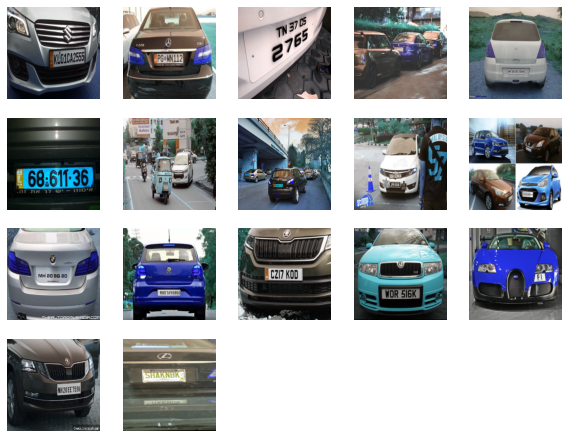

In [11]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

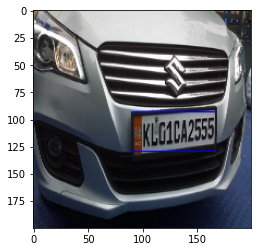

In [12]:
#Contoh dari image awal dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

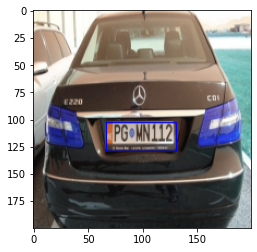

In [13]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [14]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [15]:
#Renormalisation
X = X / 255
y = y / 255

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [17]:
#CNN

from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [18]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,099,140
Trainable params: 2,384,452
Non-trainable params: 14,714,688
____________________________________

In [19]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [20]:
    rain = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
13/13 [==============================] - 45s 3s/step - loss: 0.0333 - accuracy: 0.3959 - val_loss: 0.0140 - val_accuracy: 0.5455
Epoch 2/50
13/13 [==============================] - 47s 4s/step - loss: 0.0143 - accuracy: 0.5424 - val_loss: 0.0092 - val_accuracy: 0.5227
Epoch 3/50
13/13 [==============================] - 51s 4s/step - loss: 0.0084 - accuracy: 0.6401 - val_loss: 0.0059 - val_accuracy: 0.7955
Epoch 4/50
13/13 [==============================] - 50s 4s/step - loss: 0.0043 - accuracy: 0.7969 - val_loss: 0.0063 - val_accuracy: 0.7955
Epoch 5/50
13/13 [==============================] - 54s 4s/step - loss: 0.0030 - accuracy: 0.7918 - val_loss: 0.0051 - val_accuracy: 0.6364
Epoch 6/50
13/13 [==============================] - 56s 4s/step - loss: 0.0020 - accuracy: 0.8766 - val_loss: 0.0042 - val_accuracy: 0.7500
Epoch 7/50
13/13 [==============================] - 61s 5s/step - loss: 0.0014 - accuracy: 0.9023 - val_loss: 0.0040 - val_accuracy: 0.8636
Epoch 8/50
13/13 [==

In [21]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 84.09%


In [29]:
def plot_graphs(history, string):
  epochs = range(len(history.history[string]))
  plt.plot(epochs, history.history[string],'r', label=string)
  plt.plot(epochs, history.history['val_'+string],'b',label=string+'_val')
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+string])
  plt.show()

# def plot_scores(train) :
#     accuracy = train.history['accuracy']
#     val_accuracy = train.history['val_accuracy']
#     epochs = range(len(accuracy))
#     plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
#     plt.plot(epochs, val_accuracy, 'r', label='Score validation')
#     plt.title('Scores')
#     plt.legend()
#     plt.show()

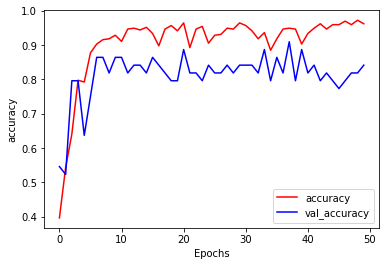

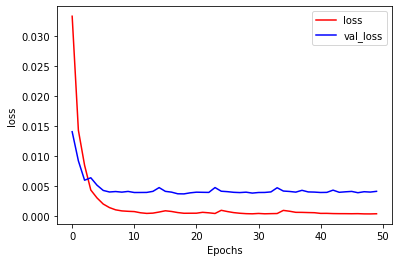

In [30]:
plot_graphs(rain,"accuracy")
plot_graphs(rain,"loss")

In [31]:
#DETECTION

y_cnn = model.predict(X_test)

In [32]:
y_cnn.shape

(44, 4)